# Skeletons

Often in thinking about neurons, you want to measure things along a linear dimension of a neuron. However, the segmentation is a full complex 3d shape that makes this non-trivial. There are methods for reducing the shape of a segmented neuron down to a linear tree like structure usually referred to as a skeleton. We have precalculated skeletons for a large number of cells in the dataset, including all the proofread cells, and many of the excitatory cells with a single soma in the dataset, and these are available on the harddrives and in the aws directory. These skeletons are stored in an h5 file format, and also contain annotations on the skeletons that have the synapses, which skeleton nodes are axon and which are dendrite, and which are likely the apical dendrite of excitatory neurons.

### Some Background: 
In order to understand these skeletons, you have to understand how large scale EM data is represented. Portions of 3d space are broken up into chunks, such as the grid in the image above. Neurons, such as the cartoon green cell above, span many chunks. Components of the segmentation that live within a single chunk are called level 2 ids, this is because in fact the chunks get iteratively combined into larger chunks, until the chunks span the whole volume. We call this the PyChunkedGraph or PCG, after the library which we use to store and interact with this represenation. Level 0 is the voxels, level 1 refers to the grouping of voxels within the chunk (also known as supervoxels) and level 2 are the groups of supervoxels within a chunk. A segmentation result can be thought of as a graph at any of these levels, where the voxels, supervoxels, or level 2 ids that are part of the same object are connected. In the above diagram, the PCG level 2 graph is represented as the light red lines.

Such graphs are useful in that they track all the parts of the neuron that are connected to one another, but they aren’t skeletons, because the graph is not directed, and isn’t a simple branching structure.

In order to turn them into a skeleton we have to run an algorithm, that finds a tree like structure that covers the graph and gets close to every node. This is called the TEASAR algorithm and you can read more about how to skeletonize graphs in the [MeshParty documentation](https://meshparty.readthedocs.io/en/latest/guide/skeletons.html?highlight=teasar).



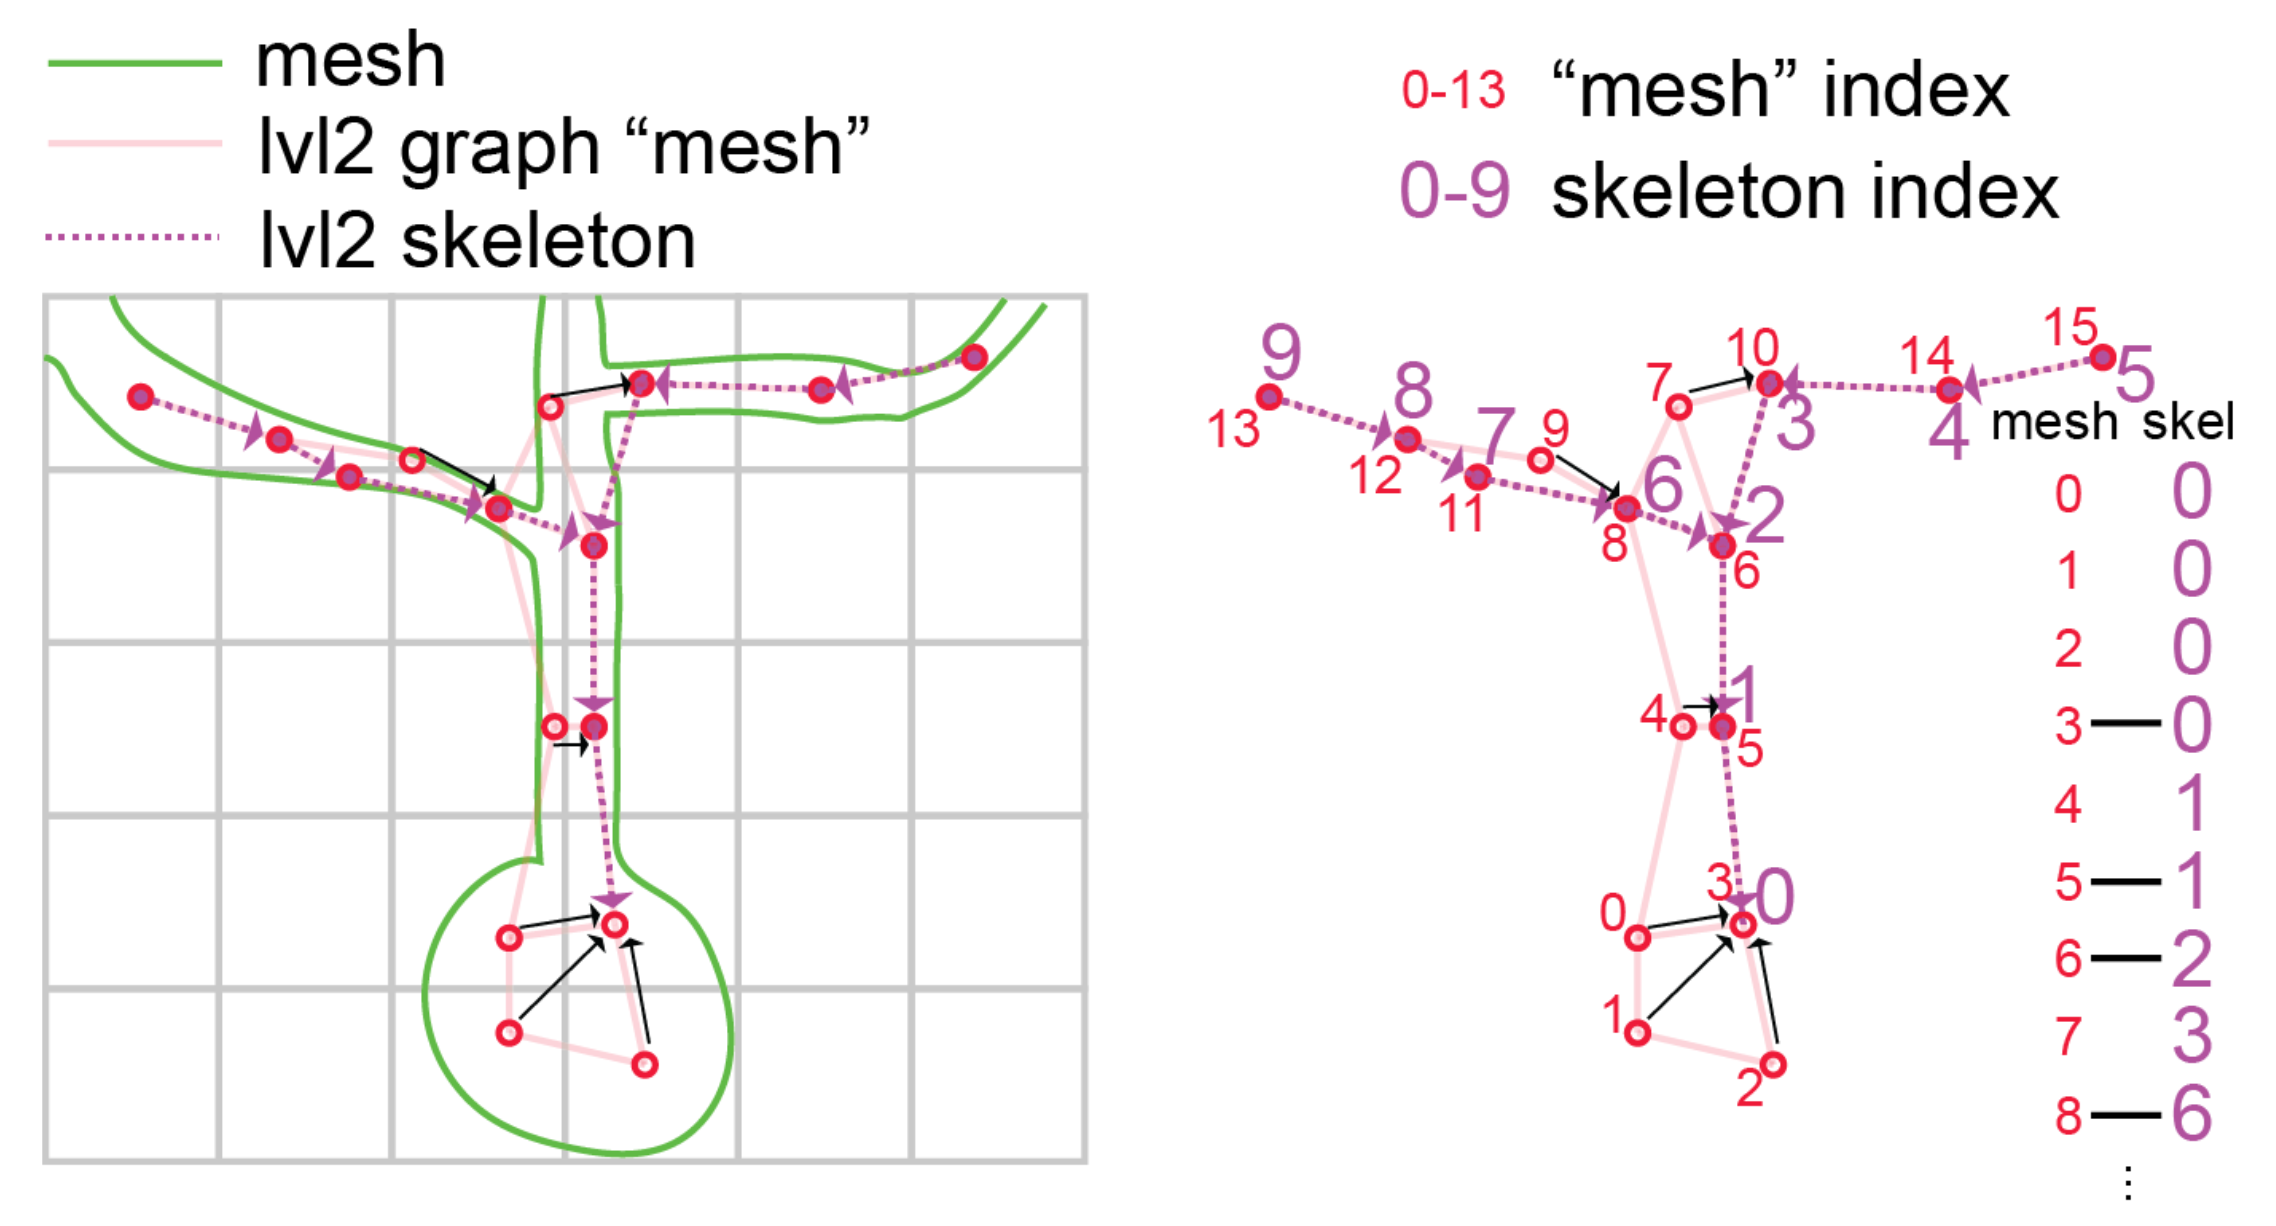

The result of the algorithm, when applied to a level 2 graph, is a linear tree (like the dotted purple one shown above), where a subset of the level 2 chunks are vertices in that tree, but all the unused level 2 nodes “near” a vertex (red unfilled circles) on the graph are mapped to one of the skeleton vertices (black arrows). This means there are two sets of indices, mesh indices, and skeleton indices, which have a mapping between them (see diagram above).

The Meshwork library allows us to easily store these representations and helps us relate them to each other. A Meshwork object is a data structure that is designed to have three main components that are kept in sync with mesh and skeleton indices:

- mesh: the graph of PCG level2 ID nodes that are skeletonized, stored as a standard meshparty mesh. Note that this is not the high resolution mesh that you see in neuroglancer.

- skeleton: a meshparty skeleton,

- anno : is a class that holds dataframes and adds some extra info to keep track of indexing.

# Skeletons and their properties

To plot this skeleton in a more sophisticated way, you have to start thinking of it as a graph, and the meshwork object has a bunch of tools and properties to help you utilize the skeleton graph.

Let’s list some of the most useful ones below You access each of these with nrn.skeleton.* Use the ? to read more details about each one

### Properties

- `branch_points`: a list of skeleton vertices which are branches

- `root`: the skeleton vertice which is the soma

- `distance_to_root`: an array the length of vertices which tells you how far away from the root each vertex is

- `root_position`: the position of the root node in nanometers

- `end_points`: the tips of the neuron

- `cover_paths`: a list of arrays containing vertex indices that describe individual paths that in total cover the neuron without repeating a vertex. Each path starts at an end point and continues toward root, stopping once it gets to a vertex already listed in a previously defined path. Paths are ordered to start with the end points farthest from root first. Each skeleton vertex appears in exactly one cover path.

- `csgraph`: a scipy.sparse.csr.csr_matrix containing a graph representation of the skeleton. Useful to do more advanced graph operations and algorithms. https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html

- `kdtree`: a scipy.spatial.ckdtree.cKDTree containing the vertices of skeleton as a kdtree. Useful for quickly finding points that are nearby. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

### Methods

- `path_length(paths=None)`: the path length of the whole neuron if no arguments, or pass a list of paths to get the path length of that. A path is just a list of vertices which are connected by edges.

- `path_to_root(vertex_index)`: returns the path to the root from the passed vertex

- `path_between(source_index, target_index)`: the shortest path between the source vertex index and the target vertex index

- `child_nodes(vertex_indices)`: a list of arrays listing the children of the vertex indices passed in

- `parent_nodes(vertex_indices)`: an array listing the parent of the vertex indices passed in

# Working with Meshworks 

Loading a meshwork file imports the level 2 graph (the “mesh”), the skeleton, and a collection of associated annotations.

The main three properties of the meshwork object are:

- `nrn.mesh` : The l2graph representation of the reconstruction.

- `nrn.skeleton` : The skeleton representation of the reconstruction.

- `nrn.anno` : A table of annotation dataframes and associated metadata that links them to specific vertices in the mesh and skeleton.

### meshwork.mesh vs meshwork.skeleton

#### Skeletons
Skeletons are “tree-like”, where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices. Because of this, for a skeleton there are well-defined directions “away from root” and “towards root” and few types of vertices have special names:

- Branch point: vertices with two or more children, where a neuronal process splits.

- End point: vertices with no childen, where a neuronal process ends.

- Root point: The one vertex with no parent node. By convention, we typically set the root vertex at the cell body, so these are equivalent to “away from soma” and “towards soma”.

Segment: A collection of vertices along an unbranched region, between one branch point and the next end point or branch point downstream.

#### Meshes
Meshes are arbitrary collections of vertices and edges, but do not have a notion of “parent” or “child” “branch point” or “end point”. Here, this means the “mesh” used here includes a vertex for every level 2 chunk, even where it is thick like at a cell body or very thick dendrite. However, by default this means that there is not always a well-defined notion of parent or child nodes, or towards or away from root.

In contrast “Meshes” (really, graphs of connected vertices) do not have a unique “inward” and “outward” direction. For the sake of rapid skeletonization, the “meshes” we use here are really the graph of level 2 vertices as described above. These aren’t a mesh in the visualization sense of the section on downloading Meshes, but have the same data representation.

To handle this, the meshwork object associates each mesh vertices with a single nearby skeleton vertex, and each skeleton vertex is associated with one or more mesh vertices. By representing data this way, annotations like synapses can be directly associated with a mesh vertex (because synapses can be anywhere on the object) and then mapped to the skeleton in order to enjoy the topological benefits of the skeleton representation.

# Task 1

- Start with one neuron with a root id [from this google sheet](https://docs.google.com/spreadsheets/d/1adZ6f8zx691_mgQxFlTHUI0mhlNiIDtyobdt6CSVNBM/edit?usp=sharing) and download the mesh
- Create a meshwork object with your mesh
- Skeletonize your cell, check that your meshwork has both skeleten and mesh based indices and vertices. How many branchpoints does your neuron have, and end points? What might you want to measure using this information? 
- Visualize your skeleton, how does it compare to the mesh? What might be the benefits and limitations of using meshes versus skeletons?

In [ ]:
from meshparty import meshwork
from caveclient import CAVEclient
client = CAVEclient('minnie65_public')

# Indexing And Selecting Sets of Points
The meshworks object contains a mesh with lots of vertices and a skeleton which holds a subset of these vertices. Therefore, in python these points have different “indices” in the mesh and skeleton. For example, if the mesh contains 10000 vertices, the indexing of those would run from 0 - 9999. The skeleton, which contains a subset of 100 of these would have indexing from 0-99. How would you figure out which of the mesh vertices these correspond to?

Luckily, we have some really nifty functions that help us distinguish those:

Let us first look at some attributes in the meshworks objects:

A few nifty function for subselecting points: `downstream points` and `path_between`. For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. 


`path_between` returns the vertices from one point to another. For example, we can get the every mesh vertex from the end point 5 to the root point. As a quick visualization, we can look at the distance to root along the, showing that it is descreasing.

# Masking

Just like meshes, we can mask the meshwork object. Like all basic meshwork functions, the expected input is in mesh vertices. Importantly, doing so will be synchronized across the mesh, the skeleton, and annotations.

While `mask_context` acts to mask the skeleton and then unmasks it at the end of operations, you can also just mask a skeleton and let it stay that way. In that case, use the `nrn.apply_mask function`.

#### Note: Do not use the `nrn.mesh.apply_mask` or `nrn.skeleton.apply_mask functions`, as they will not synchronize the mask across the mesh, skeleton, and annotations.

# Annotations

`nrn.anno` has set of annotation tables containing some additional information for analysis. Each annotation table has both a Pandas DataFrame object storing data and additional information that allow the rows of the DataFrame to be mapped to mesh and skeleton vertices. Some example annotations you can store include the following:

- `post_syn`: Postsynaptic sites (inputs) for the cell

- `pre_syn`: Presynaptic sites (outputs) for the cell

- `is_axon': List of vertices that have been labeled as part of the axon

- `lvl2_ids`: Gives the PCG level 2 id for each mesh vertex, largely for book-keeping reasons.

- `segment_properties`: For each vertex, information about the approximate radius, surface area, volume, and length of the segment it is on.

- `vol_prop`: For every vertex, information about the volume and surface area of the level 2 id it is associated with.

You can also easily get the mesh vertex index or skeleton vertex index that a row corresponds to with `nrn.anno.post_syn.mesh_index` or `nrn.anno.post_syn.skel_index` respectively. This seems small, but it allows you to integrate skeleton-like measurements with annotations trivially.

# Task 2
- Adding on to your meshwork from Task 1, and your previous work in Sessions 1 and 2; access the synapse table, `synapses_pni_v2`, through the caveclient and query for both the pre and post synapses of your cell. Add them as annotations to your meshwork
- Can you visualize your skeleton, creating a separate point actor for your pre and post synapses
- Create a mask for your skeleton and visualize the only those synapses.
- Can you create a mask for just the axon of your cell? How about the dendrite? What types of analysis might this enable?